In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import math

In [22]:
# def f(x):
#     return x*x

# def fDeriv(x):
#     return 2*x
def f(x):
    return (x * x * x * x * x) + (x * x * x) + x - 10

def fDeriv(x):
    return 5 * x*x*x*x + 3*x*x + 1

# def f(x):
#     return x**2 * (1-x)**3

# def fDeriv(x):
#     return 0

# 2x (1-x)^3 + 3*(1-x)^2*2x
# 0: 0
# 1: 0


def f(x):
    return math.sin(20*x)**3

def fDeriv(x):
    if x == 0 or x == math.pi/2:
        return 0
    return 60 * (math.sin(20*x)**2) * math.cos(20*x)



In [23]:
# равноотстоящие узлы
def createEquallySpacedPoints(a,b,N):
    """ 
    (x_0,...,x_N) -- N+1 точка

    """
    X = []
    H = []
    x_ = a
    for i in range(N+1):
        x = a + i * (b-a)/N
        # y = f(x)
        X.append(x)
        H.append(x-x_)
        x_ = x  
    H.pop(0)
    return X, H


# чтение из файла
def createPointsFromFile(filename):
     
    """ 
    (x_0,...,x_N) -- N+1 точка
    
    """
    X = []
    H = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        if lines:
            first_x = float(lines[0].strip())
            X.append(first_x)
            x_ = first_x
            
            for line in lines[1:]:
                x = float(line.strip())
                # y = f(x)
                X.append(x)
                H.append(x - x_)
                x_ = x
            
    return X, H





In [24]:
def createVecF(X):
    """ 
    F = (f'(x_0), f(x_1), ..., f(x_{N-1}), f'(x_N))
    """
    N = len(X) # подразумевается N+1
    F = [0.0] * N 
    F[0] = fDeriv(X[0])
    for i in range(1, N-1):
        F[i] = f(X[i])
    F[N-1] = fDeriv(X[N-1])
    return F
    


def createRightSide(H, F):
    N = len(F) # подразумевается N+1
    B = [0.0] * N
    B[0] = F[0] 
    B[N-1] = F[N-1] 
    for i in range(1, N-1):
        h_ = H[i-1]
        h = H[i]
        # print(f"h_ = {h_}, h = {h}, F[{i-1}] = {F[i-1]},  F[{i}] = {F[i]},  F[{i+1}] = {F[i+1]}")

        B[i] = ( - 1.0/(h_*h_) * F[i-1] \
                 + (1.0/(h_*h_) - 1.0/(h*h)) * F[i] \
                 + 1.0/(h*h) * F[i+1] ) * 3.0 
               
    return B

def createMatrix(N, H):
    M = [[0.0 for _ in range(N+1)] for _ in range(N+1)]
    for i in range(N+1):  
        if i == 0:
            M[0][0] = 1.0
        elif i == N:   
            M[N][N] = 1.0 
        else:
            h_ = H[i-1]   
            h  = H[i]        
            M[i][i - 1] = 1.0 / h_
            M[i][i] = 2.0 / h_ + 2.0 / h 
            M[i][i + 1] = 1.0 / h 
    return M


In [25]:
def solveTridiag(M, f):
    """
    Решение трехдиагональной системы методом прогонки
    
    Параметры:
    a - нижняя диагональ 
    c - главная диагональ
    b - верхняя диагональ
    f - правая часть
    
    Возвращает:
    y - решение системы
    """

    N = len(f)  # подразумевается N+1
    N -= 1

    alpha = [0.0] * (N+1)  
    beta  = [0.0] * (N+1)
    y = [0.0] * (N+1)

    a = [0.0] * (N+1)  
    b = [0.0] * (N+1) 
    c = [0.0] * (N+1)  
    
    # b[0]   =  - 1.0 * M[0][1]
    # a[N-1] =  - 1.0 * M[N][N-1]
    b[0] = 0.0
    a[N] = 0.0

    for i in range(N+1):
        c[i] = M[i][i]
        if (i > 0 and i < N):
            a[i] = - 1.0 * M[i][i-1]
            b[i] = - 1.0 * M[i][i+1]
    
    # Прямой ход 
    alpha[1] = b[0] / c[0]
    beta[1] = f[0] / c[0]
    
    for i in range(1, N):
        denom = c[i] - a[i] * alpha[i]
        alpha[i + 1] = b[i] / denom
        beta[i + 1]  = (f[i] + a[i] * beta[i]) / denom
    
    denom = c[N] - a[N] * alpha[N]
    y[N] = (f[N] + a[N] * beta[N]) / denom
    
    # Обратный ход 
    for i in range(N-1, -1, -1):
        y[i] = alpha[i + 1] * y[i + 1] + beta[i + 1]
    
    return y



In [26]:
def buildSpline(x, xi, xi_, h, m_, m, fi_, fi):
    A = (x-xi) * (x-xi) * (x-xi_) / (h*h)
    B = (x-xi_)*(x-xi_) * (x-xi) / (h*h)
    C = (x-xi) * (x-xi) * (2.*(x - xi_) + h) / (h*h*h)
    D = (x-xi_)*(x-xi_) * (2.*(x - xi) - h)  / (-h*h*h) 

    return A*m_ + B*m + C*fi_ + D*fi

def buildAllSplines(X, y, F):

    N = len(X) - 1
   
    F[0] = f(X[0])
    F[N] = f(X[N])
    splines = []
    
    for i in range(1,N+1):
        xi_ = X[i-1]      
        xi  = X[i]   
        h   = xi - xi_   
        
        m_ = y[i-1]      
        m  = y[i]    
        fi_ = F[i-1]   
        fi  = F[i]  
        
        # Создаем лок сплайн для этого отрезка
        def spline_func(x, xi=xi, xi_=xi_, h=h, m_=m_, m=m, fi_=fi_, fi=fi):
            return buildSpline(x, xi, xi_, h, m_, m, fi_, fi)
        
        splines.append((xi_, xi, spline_func))
    
    return splines


def splineValue(x, splines):
    """Возвращает значение сплайна в точке x"""
    for (xLeft, xRight, Sloc) in splines:
        if xLeft <= x <= xRight:
            return Sloc(x)
    # если вне диапазона
    if x < splines[0][0]:
        return splines[0][2](x)
    return splines[-1][2](x)



    # N = len(X)
    # F[0] = f(X[0])
    # F[N] = f(X[N])
    # splines = []
    # xi_ = x[0]
    # xi  = x[1]
    # # h_  = H[0]
    # # h   = H[1]

    # for x in X:

    #     h = H[i]

        




In [27]:
N = 3
X, H = createEquallySpacedPoints(0,2,N)

# N = 10
# X, H = createEquallySpacedPoints(0, math.pi/2, N)


# X, H = createPointsFromFile("nodes.txt")
# N = len(X) - 1

F = createVecF(X)
B = createRightSide(H, F)
A = createMatrix(N, H)
y = solveTridiag(A, B)

print(f" X = {X}")
print(f" H = {H}")
print(f" F = {F}")
print(f" B = {B}\n\n")

for row in A:
    print([f"{val:.2f}" for val in row])
print(f" y =  {y}")

splines = buildAllSplines(X, y, F)

print("Значения сплайна в узлах:")
for x in X:
    val = splineValue(x, splines)
    print(f"S({x:.3f}) = {val:.6f}   (f(x) = {f(x):.6f})")



# H

 X = [0.0, 0.6666666666666666, 1.3333333333333333, 2.0]
 H = [0.6666666666666666, 0.6666666666666666, 0.6666666666666667]
 F = [0, 0.3341853608129533, 0.997962422815917, -22.216785482682358]
 B = [0, 6.73624635400744, -152.21905319359334, -22.216785482682358]


['1.00', '0.00', '0.00', '0.00']
['1.50', '6.00', '1.50', '0.00']
['0.00', '1.50', '6.00', '1.50']
['0.00', '0.00', '0.00', '1.00']
 y =  [0.0, 6.4817271282488695, -21.436077610323853, -22.216785482682358]
Значения сплайна в узлах:
S(0.000) = 0.000000   (f(x) = 0.000000)
S(0.667) = 0.334185   (f(x) = 0.334185)
S(1.333) = 0.997962   (f(x) = 0.997962)
S(2.000) = 0.413682   (f(x) = 0.413682)


         x       f(x)       S(x)  |f(x)-S(x)|
  0.000000   0.000000   0.000000     0.000000
  0.016667   0.035028   0.035028     0.000000
  0.033333   0.236453   0.236453     0.000000
  0.050000   0.595823   0.595823     0.000000
  0.066667   0.918154   0.918154     0.000000
  0.083333   0.986287   0.986287     0.000000
  0.100000   0.751827   0.751827     0.000000
  0.116667   0.378068   0.378068     0.000000
  0.133333   0.095615   0.095615     0.000000
  0.150000   0.002810   0.002810     0.000000
  0.166667  -0.006921  -0.006921     0.000000
  0.183333  -0.125960  -0.125960     0.000000
  0.200000  -0.433459  -0.433459     0.000000
  0.216667  -0.801803  -0.801803     0.000000
  0.233333  -0.996868  -0.996868     0.000000
  0.250000  -0.881765  -0.881765     0.000000
  0.266667  -0.538021  -0.538021     0.000000
  0.283333  -0.193299  -0.193299     0.000000
  0.300000  -0.021815  -0.021815     0.000000
  0.316667   0.000126   0.000126     0.000000
  0.333333   0.052377   0.052377  

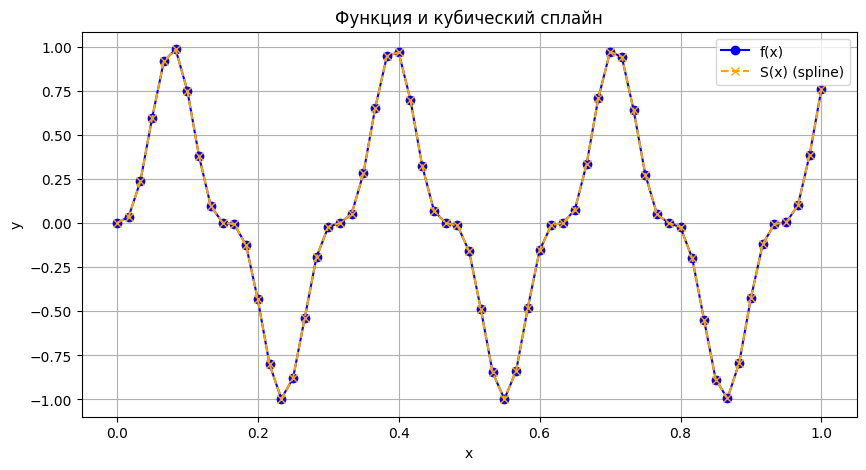

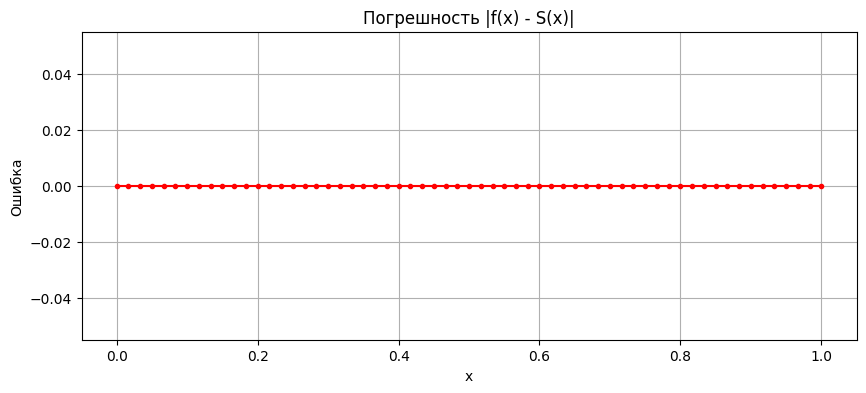

In [28]:

def insertPointsX(X, k):
    """
    Вставляет k дополнительных точек между каждым соседним узлом.
    
    X — список узлов [x0, x1, ..., xN]
    k — сколько точек вставлять между каждой парой
    """
    extendedX = []
    for i in range(len(X) - 1):
        x_ = X[i]
        x = X[i + 1]
        extendedX.append(x_)
        for j in range(1, k + 1):
            xNew = x_ + j * (x - x_) / (k + 1)
            extendedX.append(xNew)
    extendedX.append(X[-1])
    return extendedX


# N = 100
# X, H = createEquallySpacedPoints(0, math.pi/2.0, N)


N = 60
X, H = createEquallySpacedPoints(0, 1, N)


# X, H = createPointsFromFile("nodes.txt")
# N = len(X) - 1


F = createVecF(X)
B = createRightSide(H, F)
A = createMatrix(N, H)
Y = solveTridiag(A, B)
splines = buildAllSplines(X, Y, F)

XX = insertPointsX(X, k=0)   

data = []
for x in XX:
    fx = f(x)
    sx = splineValue(x, splines)
    err = abs(fx - sx)
    data.append((x, fx, sx, err))

df = pd.DataFrame(data, columns=['x', 'f(x)', 'S(x)', '|f(x)-S(x)|'])
print(df.to_string(index=False, float_format=lambda v: f"{v:10.6f}"))

xVals = [d[0] for d in data]
fVals = [d[1] for d in data]
sVals = [d[2] for d in data]
errVals = [d[3] for d in data]

with open("error.txt", "w") as fout:
    fout.write(f"{'x':>10} {'f(x)':>15} {'S(x)':>15} {'|f(x)-S(x)|':>15}\n")
    fout.write("-" * 60 + "\n")
    for x, fx, sx, err in data:
        fout.write(f"{x:10.6f} {fx:15.8f} {sx:15.8f} {err:15.8e}\n")

max_err = max(abs(fx - sx) for _, fx, sx, _ in data)
print(f"\n Максимальная ошибка: {max_err:.6e}")

plt.figure(figsize=(10,5))
plt.plot(xVals, fVals, 'o-', label='f(x)', color='blue')
plt.plot(xVals, sVals, 'x--', label='S(x) (spline)', color='orange')
plt.title("Функция и кубический сплайн")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(xVals, errVals, 'r.-')
plt.title("Погрешность |f(x) - S(x)|")
plt.xlabel("x")
plt.ylabel("Ошибка")
plt.grid(True)
plt.show()


In [29]:
# %pip install pandas

In [30]:
def createPointsFromFile2(filename):
     
    """ 
    (x_0,...,x_N) -- N+1 точка
    
    """
    X = []
    F = []
    F_ = []
    W = []
    H = []
    # F[0] = 0

    with open(filename, 'r') as file:
        lines = file.readlines()        
        if lines:
            for line in lines:
                values = line.strip().split()
                if len(values) >= 3:
                    x = float(values[0])
                    f = float(values[1])
                    w = float(values[2])
                    
                    X.append(x)
                    F.append(f)
                    F_.append(f)
                    W.append(w)
            if len(X) > 1:
                for i in range(1, len(X)):
                    H.append(X[i] - X[i-1])
    return X, F, F_, W, H


Ошибки в узлах:
         x  f(x) из файла       S(x)  |f(x)-S(x)|
  7.990000       0.000000   0.068357     0.068357
  8.090000       0.000028   0.000028     0.000000
  8.190000       0.043750   0.043750     0.000000
  8.700000       0.169183   0.169183     0.000000
  9.200000       0.469428   0.469428     0.000000
 10.000000       0.943740   0.943740     0.000000
 12.000000       0.998636   0.998636     0.000000
 15.000000       0.999916   0.999916     0.000000
 20.000000       0.999994  -0.616120     1.616114

Максимальная ошибка в узлах: 1.616114e+00


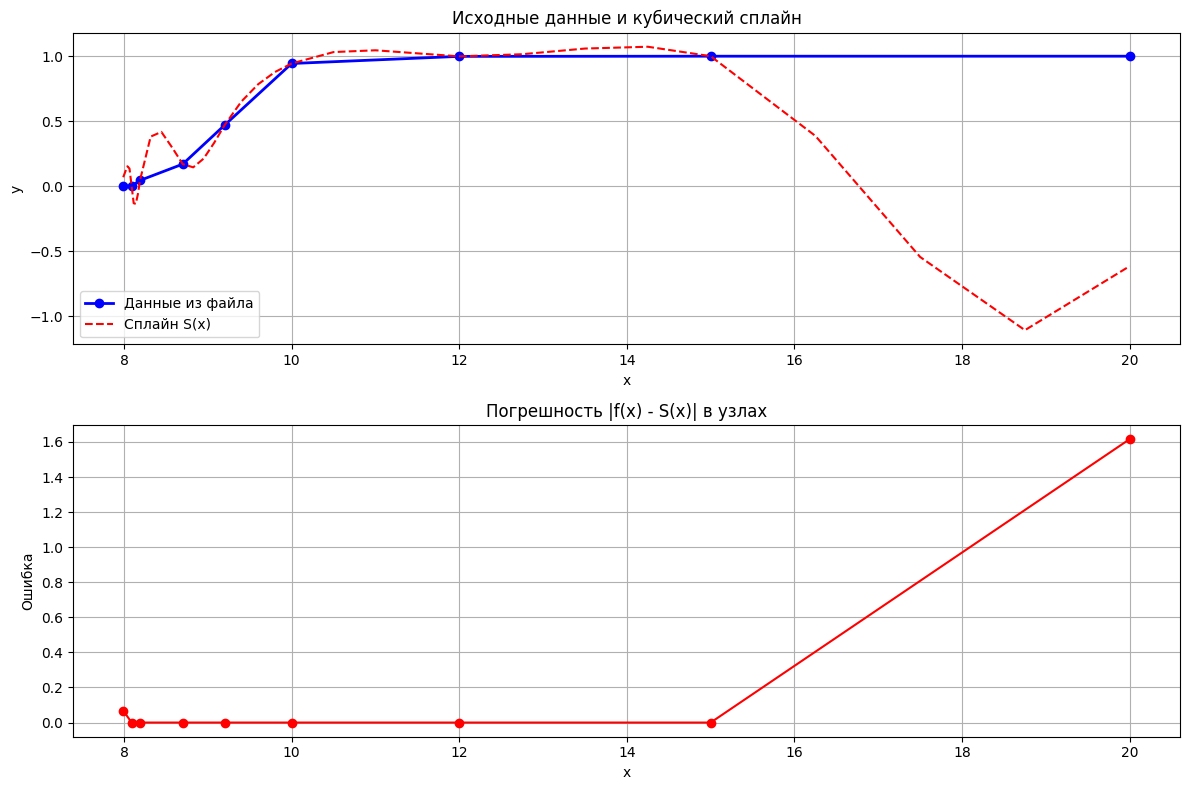

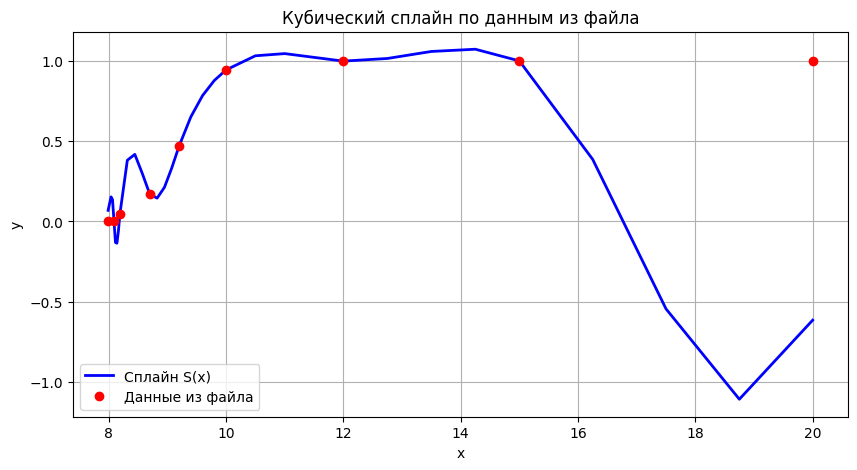

In [31]:
# X, H = createPointsFromFile("nodes.txt")
# N = len(X) - 1
X, F, F_, W, H = createPointsFromFile2("nodes1.txt")
N = len(X) - 1

F_[0] = F_[N] = 1

# F = createVecF(X)
B = createRightSide(H, F_)
A = createMatrix(N, H)
Y = solveTridiag(A, B)
splines = buildAllSplines(X, Y, F_)

XX = insertPointsX(X, k=3)   # Увеличиваем k для более гладкого графика

# Для узлов используем значения из файла, для промежуточных точек - сплайн
data_nodes = []
for i, x in enumerate(X):
    file_val = F[i]  # Значение из файла
    sx = splineValue(x, splines)  # Значение сплайна
    err = abs(file_val - sx)
    data_nodes.append((x, file_val, sx, err))

data_spline = []
for x in XX:
    sx = splineValue(x, splines)
    data_spline.append((x, sx))

df = pd.DataFrame(data_nodes, columns=['x', 'f(x) из файла', 'S(x)', '|f(x)-S(x)|'])
print("Ошибки в узлах:")
print(df.to_string(index=False, float_format=lambda v: f"{v:10.6f}"))

xNodes = [d[0] for d in data_nodes]
fNodes = [d[1] for d in data_nodes]  
sNodes = [d[2] for d in data_nodes]
errNodes = [d[3] for d in data_nodes]

xSpline = [d[0] for d in data_spline]
sSpline = [d[1] for d in data_spline]  # Значения сплайна в промежуточных точках

with open("error.txt", "w") as fout:
    fout.write(f"{'x':>10} {'f(x) из файла':>15} {'S(x)':>15} {'|f(x)-S(x)|':>15}\n")
    fout.write("-" * 60 + "\n")
    for x, fx, sx, err in data_nodes:
        fout.write(f"{x:10.6f} {fx:15.8f} {sx:15.8f} {err:15.8e}\n")

max_err = max(errNodes)
print(f"\nМаксимальная ошибка в узлах: {max_err:.6e}")

# Строим графики
plt.figure(figsize=(12, 8))

# Первый график: исходные данные и сплайн
plt.subplot(2, 1, 1)
# Исходные данные из файла
plt.plot(xNodes, fNodes, 'o-', label='Данные из файла', color='blue', markersize=6, linewidth=2)
# Сплайн (гладкая кривая)
plt.plot(xSpline, sSpline, '--', label='Сплайн S(x)', color='red', linewidth=1.5)
plt.title("Исходные данные и кубический сплайн")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Второй график: ошибка в узлах
plt.subplot(2, 1, 2)
plt.plot(xNodes, errNodes, 'ro-', markersize=6)
plt.title("Погрешность |f(x) - S(x)| в узлах")
plt.xlabel("x")
plt.ylabel("Ошибка")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(xSpline, sSpline, 'b-', label='Сплайн S(x)', linewidth=2)
plt.plot(xNodes, fNodes, 'ro', label='Данные из файла', markersize=6)
plt.title("Кубический сплайн по данным из файла")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

=== ОБРАБОТКА ДАННЫХ ИЗ ФАЙЛА ===
 X = [7.99, 8.09, 8.19, 8.7, 9.2, 10.0, 12.0, 15.0, 20.0]
 H = [0.09999999999999964, 0.09999999999999964, 0.5099999999999998, 0.5, 0.8000000000000007, 2.0, 3.0, 5.0]
 F_file = [0.0, 2.76429e-05, 0.0437498, 0.169183, 0.469428, 0.94374, 0.998636, 0.999916, 0.999994]
 B = [0.000276429000000001, 13.042011300000093, 14.56339684164946, 5.049689711649368, 5.826277499999996, 2.264509499999996, 0.04159866666666667, -0.11956138133333333, 1.56000000000045e-05]


Матрица системы:
['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['10.0000', '40.0000', '10.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '10.0000', '23.9216', '1.9608', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '1.9608', '7.9216', '2.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '0.0000', '2.0000', '6.5000', '1.2500', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '0.0000', '0

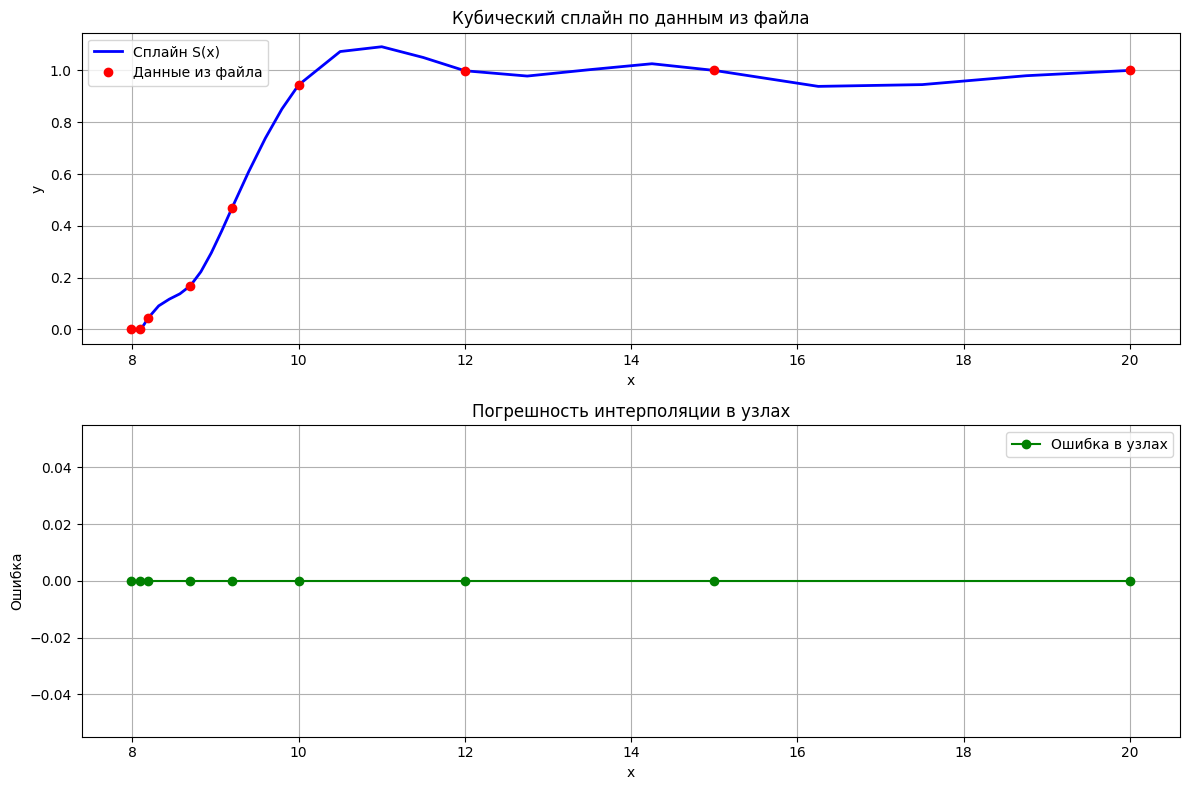


Максимальная ошибка в узлах: 0.000000e+00


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def createPointsFromFile2(filename):
    """ 
    (x_0,...,x_N) -- N+1 точка
    """
    X = []
    F = []
    W = []
    H = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()        
        if lines:
            for line in lines:
                values = line.strip().split()
                if len(values) >= 3:
                    x = float(values[0])
                    f_val = float(values[1])
                    w = float(values[2])
                    
                    X.append(x)
                    F.append(f_val)
                    W.append(w)
            
            if len(X) > 1:
                for i in range(1, len(X)):
                    H.append(X[i] - X[i-1])
    return X, F, W, H

def createVecF(X, F_file):
    """ 
    F = (f'(x_0), f(x_1), ..., f(x_{N-1}), f'(x_N))
    Для файловых данных используем численные производные на границах
    """
    N = len(X) - 1
    F = [0.0] * (N + 1) 
    
    # Численная оценка производных на границах
    if len(X) >= 2:
        m0 = (F_file[1] - F_file[0]) / (X[1] - X[0])
        mN = (F_file[N] - F_file[N-1]) / (X[N] - X[N-1])
    else:
        m0 = 0
        mN = 0
    
    F[0] = m0
    for i in range(1, N):
        F[i] = F_file[i]
    F[N] = mN
    
    return F

def createRightSide(H, F):
    N = len(F) - 1
    B = [0.0] * (N + 1)
    B[0] = F[0] 
    B[N] = F[N] 
    
    for i in range(1, N):
        h_ = H[i-1]
        h = H[i]
        
        B[i] = ( - 1.0/(h_*h_) * F[i-1] \
                 + (1.0/(h_*h_) - 1.0/(h*h)) * F[i] \
                 + 1.0/(h*h) * F[i+1] ) * 3.0 
               
    return B

def createMatrix(N, H):
    M = [[0.0 for _ in range(N+1)] for _ in range(N+1)]
    
    for i in range(N+1):  
        if i == 0:
            M[0][0] = 1.0
        elif i == N:   
            M[N][N] = 1.0 
        else:
            h_ = H[i-1]   
            h  = H[i]        
            M[i][i - 1] = 1.0 / h_
            M[i][i] = 2.0 / h_ + 2.0 / h 
            M[i][i + 1] = 1.0 / h 
    return M

def solveTridiag(M, f):
    N = len(f) - 1

    alpha = [0.0] * (N+1)  
    beta  = [0.0] * (N+1)
    y = [0.0] * (N+1)

    a = [0.0] * (N+1)  
    b = [0.0] * (N+1) 
    c = [0.0] * (N+1)  
    
    b[0] = 0.0
    a[N] = 0.0

    for i in range(N+1):
        c[i] = M[i][i]
        if (i > 0 and i < N):
            a[i] = -1.0 * M[i][i-1]
            b[i] = -1.0 * M[i][i+1]
    
    # Прямой ход 
    alpha[1] = b[0] / c[0]
    beta[1] = f[0] / c[0]
    
    for i in range(1, N):
        denom = c[i] - a[i] * alpha[i]
        alpha[i + 1] = b[i] / denom
        beta[i + 1] = (f[i] + a[i] * beta[i]) / denom
    
    denom = c[N] - a[N] * alpha[N]
    y[N] = (f[N] + a[N] * beta[N]) / denom
    
    # Обратный ход 
    for i in range(N-1, -1, -1):
        y[i] = alpha[i + 1] * y[i + 1] + beta[i + 1]
    
    return y

def buildSpline(x, xi, xi_, h, m_, m, fi_, fi):
    A = (x-xi) * (x-xi) * (x-xi_) / (h*h)
    B = (x-xi_)*(x-xi_) * (x-xi) / (h*h)
    C = (x-xi) * (x-xi) * (2.*(x - xi_) + h) / (h*h*h)
    D = (x-xi_)*(x-xi_) * (2.*(x - xi) - h)  / (-h*h*h) 

    return A*m_ + B*m + C*fi_ + D*fi

def buildAllSplines(X, y, F_file):
    N = len(X) - 1
   
    splines = []
    
    for i in range(1, N+1):
        xi_ = X[i-1]      
        xi  = X[i]   
        h   = xi - xi_   
        
        m_ = y[i-1]      
        m  = y[i]    
        fi_ = F_file[i-1]   
        fi  = F_file[i]  
        
        def spline_func(x, xi=xi, xi_=xi_, h=h, m_=m_, m=m, fi_=fi_, fi=fi):
            return buildSpline(x, xi, xi_, h, m_, m, fi_, fi)
        
        splines.append((xi_, xi, spline_func))
    
    return splines

def splineValue(x, splines):
    for (xLeft, xRight, Sloc) in splines:
        if xLeft <= x <= xRight:
            return Sloc(x)
    if x < splines[0][0]:
        return splines[0][2](x)
    return splines[-1][2](x)

def insertPointsX(X, k):
    extendedX = []
    for i in range(len(X) - 1):
        x_ = X[i]
        x = X[i + 1]
        extendedX.append(x_)
        for j in range(1, k + 1):
            xNew = x_ + j * (x - x_) / (k + 1)
            extendedX.append(xNew)
    extendedX.append(X[-1])
    return extendedX

# Основная программа для данных из файла
print("=== ОБРАБОТКА ДАННЫХ ИЗ ФАЙЛА ===")

X, F_file, W, H = createPointsFromFile2("nodes1.txt")
N = len(X) - 1

print(f" X = {X}")
print(f" H = {H}")
print(f" F_file = {F_file}")

F_vec = createVecF(X, F_file)
B = createRightSide(H, F_vec)
A = createMatrix(N, H)
y = solveTridiag(A, B)

print(f" B = {B}\n\n")

print("Матрица системы:")
for row in A:
    print([f"{val:.4f}" for val in row])
print(f" y =  {y}")

# Проверка граничных условий
print(f"m[0] = {y[0]}, оцененная f'({X[0]}) = {F_vec[0]}")
print(f"m[{N}] = {y[N]}, оцененная f'({X[N]}) = {F_vec[N]}")

splines = buildAllSplines(X, y, F_file)

print("Значения сплайна в узлах:")
for i, x in enumerate(X):
    val = splineValue(x, splines)
    file_val = F_file[i]
    error = abs(val - file_val)
    print(f"S({x:.3f}) = {val:.6f}   (f(x) из файла = {file_val:.6f}, ошибка = {error:.6f})")

# Визуализация
XX = insertPointsX(X, k=3)
data = []
for x in XX:
    sx = splineValue(x, splines)
    data.append((x, sx))

xVals = [d[0] for d in data]
sVals = [d[1] for d in data]

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(xVals, sVals, 'b-', label='Сплайн S(x)', linewidth=2)
plt.plot(X, F_file, 'ro', markersize=6, label='Данные из файла')
plt.title('Кубический сплайн по данным из файла')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
errors = []
for i, x in enumerate(X):
    spline_val = splineValue(x, splines)
    error = abs(spline_val - F_file[i])
    errors.append(error)
plt.plot(X, errors, 'go-', label='Ошибка в узлах')
plt.title('Погрешность интерполяции в узлах')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

max_error = max(errors)
print(f"\nМаксимальная ошибка в узлах: {max_error:.6e}")

# Сохранение результатов
with open("spline_results.txt", "w") as fout:
    fout.write(f"{'x':>10} {'f(x)_file':>15} {'S(x)':>15} {'Error':>15}\n")
    fout.write("-" * 60 + "\n")
    for i, x in enumerate(X):
        spline_val = splineValue(x, splines)
        error = abs(spline_val - F_file[i])
        fout.write(f"{x:10.6f} {F_file[i]:15.8f} {spline_val:15.8f} {error:15.8e}\n")